In [ ]:
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
#!conda install -y -c conda-forge wordcloud

In [2]:
%reset -f

import gc
# This module provides an interface to the optional garbage collector. It provides the ability to disable the collector, tune the collection frequency, 
# and set debugging options.

import re
# This module provides regular expression matching operations similar to those found in Perl.

import string

import operator
# The operator module exports a set of efficient functions corresponding to the intrinsic operators of Python. For example, 
# operator.add(x, y) is equivalent to the expression x+y

from collections import defaultdict
# This module implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.

import numpy as np
import pandas as pd

# Set the pandas dataframe to show maximum 500 rows and 500 columns and set the display width to be 1000
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
# matplotlib.pyplot is a state-based interface to matplotlib. It provides a MATLAB-like way of plotting.

import seaborn as sns
# Seaborn is a library for making statistical graphics in Python. It is built on top of matplotlib and closely integrated with pandas data structures.

from shutil import copyfile
copyfile(src = "../input/tokenization/tokenization.py", dst = "tokenization.py")
import tokenization

from wordcloud import STOPWORDS

# Simple and efficient tools for predictive data analysis
# Accessible to everybody, and reusable in various contexts
# Built on NumPy, SciPy, and matplotlib
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

# The core open source library to help you develop and train ML models. Get started quickly by running Colab notebooks directly in your browser.
import tensorflow as tf

# TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models
import tensorflow_hub as hub

# tf.keras is TensorFlow's high-level API for building and training deep learning models. It's used for fast prototyping, state-of-the-art research, and production,
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import pickle
SEED = 1337

read the csv file ensuring that the id column is of 16 bit integers and the target column is of 32 bit integers. Remember that the test file doesn't have a target column

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
- Read a comma-separated values (csv) file into DataFrame.

In [23]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

In [24]:
df_train_missing_check= df_train.copy()
df_test_missing_check= df_test.copy()

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.memory_usage.html
* Return the memory usage of each column in bytes.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html
* Return the sum of the values for the requested axis.

In [25]:
print('Training Set Shape = {}'.format(df_train.shape))
print(type(df_train.memory_usage()))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
<class 'pandas.core.series.Series'>
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## **1. Keyword and Location**

### **1.1 Missing Values**
Both training and test set have same ratio of missing values in `keyword` and `location`.
* **0.8%** of `keyword` is missing in both training and test set
* **33%** of `location` is missing in both training and test set

Since missing value ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.

make a list of the columns where you want to fill in the missing values. We will be filling the missing values for the `keyword` and the `location` column

In [27]:
missing_cols = ['keyword', 'location']

create two subplots and set the number of columns in the figure to be 2, figure size will be (15,5)

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html
* Create a figure and a set of subplots.

https://seaborn.pydata.org/generated/seaborn.barplot.html
* Show point estimates and confidence intervals as rectangular bars.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html
* Detect missing values. Return a boolean same-sized object indicating if the values are NA. NA values, such as None or numpy.NaN, gets mapped to True values.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html
* Return the sum of the values for the requested axis.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.values.html
* Return Series as ndarray or ndarray-like depending on the dtype.

https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_ylabel.html
* Set the label for the y-axis

https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_title.html
* Set a title for the axes.


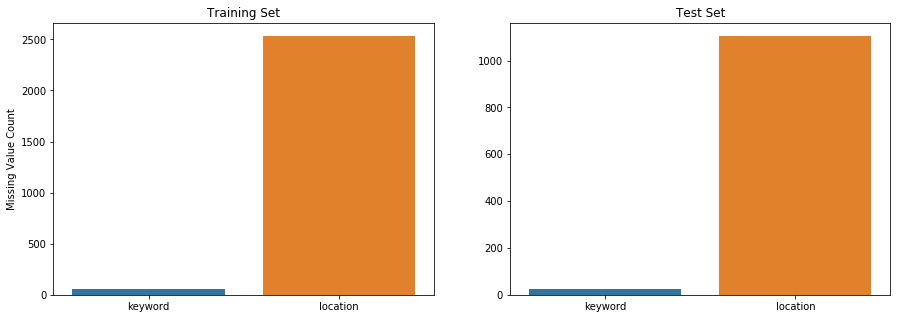

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

# create two barplots where the x axis will be the list missing_cols and y will be the number of missing values
# in those columns. Set the axis accordingly
sns.barplot(x=missing_cols, y=df_train_missing_check[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=missing_cols, y=df_test_missing_check[missing_cols].isnull().sum().values, ax=axes[1])

# set label of y axes of the first subplot
axes[0].set_ylabel('Missing Value Count')

# set title of both subplots
axes[0].set_title('Training Set')
axes[1].set_title('Test Set')

# show the plot
plt.show()

Replace the missing values with `no_`+ the name of the column

In [30]:
for df in [df_train, df_test]:
    for col in missing_cols:
        df[col] = df[col].fillna(f'no_{col}')

### **1.2 Cardinality and Target Distribution**
Locations are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.

Fortunately, there is signal in `keyword` because some of those words can only be used in one context. Keywords have very different tweet counts and target means. `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html

In [31]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


before analyzing the cardinality and target distribution of the main dataset, we will explain the process with a much simpler dataframe here:

In [33]:
data = {'keyword':  ['panic','huge','huge','panic','great','huge','panic','huge','panic','great'],
        'target': [1,0,1,1,0,0,1,0,0,0],
        }
columns=['keyword','target']
sample_df = pd.DataFrame (data, columns = columns)
sample_df

,keyword,target
0,panic,1
1,huge,0
2,huge,1
3,panic,1
4,great,0
5,huge,0
6,panic,1
7,huge,0
8,panic,0
9,great,0


We need to sort the keywords in such a way that the keywords which indicate a disaster appears on the top. So, we will create a new column which contains the average of the targets having the same keywords.

For example: the keyword 'panic' has target values 1,1,1,0. So, the value in the target_mean column for every row which has the keyword 'panic' will have the average of 1,1,1,0. (1+1+1+0)/4 = 0.75

As for the other keywords...
'huge' has an average of (0+1+0+0)/4=0.25,
'great' has an average of (0+0)/2=0

If we sort the dataframe according to the `target_mean` of the keyword in a descending order, the keywords that indicate a disaster will appear on the top.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
* Group DataFrame using a mapper or by a Series of columns.

https://pandas.pydata.org/docs/dev/reference/api/pandas.core.groupby.SeriesGroupBy.transform.html
* Call function producing a like-indexed Series on each group and return a Series having the same indexes as the original object filled with the transformed values


In [ ]:
sample_df['target_mean'] = sample_df.groupby('keyword')['target'].transform('mean')

In this seaborn countplot, we will create the countplot in such a way that the y axis will contain the keywords of the dataframe and each keyword will have two horizontal bars. The first bar will indicate the number of non-disaster-tweets that had this keyword and the second bar will indicate the number of disaster-tweets that had this keyword. Since we will plot two columns of the dataframe which was sorted by the target_mean, we will have a resulting plot which will roughly have the disaster-indicating keywords on the top of the figure

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html
* Create a new figure.

https://seaborn.pydata.org/generated/seaborn.countplot.html
* Show the counts of observations in each categorical bin using bars.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
* Sort by the values along either axis.

In [ ]:
plt.figure()

# create the countplot where the y axis represents the keyword column of the sorted `sample_df`
# and the hue represents the `target` column of the sorted `sample_df`
# remember that the sample_df is sorted by the `target_mean` column 
sns.countplot(y=sample_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=sample_df.sort_values(by='target_mean', ascending=False)['target'])
plt.show()

Now, drop the `target_mean` column because we don't need it for future calculations

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
* Drop specified labels from rows or columns
* inplace- If True, do operation inplace and return None.

In [ ]:
sample_df.drop(columns=['target_mean'], inplace=True)

Now, do the above steps on the main dataset

In [ ]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

# create a pyplot figure of figsize (8,72) and dpi of 100
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

## **2. Meta Features**
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
* Apply a function along an axis of the DataFrame

https://docs.python.org/3/reference/expressions.html#lambda
* Lambda expressions (sometimes called lambda forms) are used to create anonymous functions. The expression lambda parameters: expression yields a function object.

https://docs.python.org/3/library/functions.html#len
* Return the length (the number of items) of an object.

https://docs.python.org/3/library/stdtypes.html#str
* Return a string version of the argument

https://docs.python.org/3/library/stdtypes.html#str.split
* Return a list of the words in the string, using sep as the delimiter string.

https://docs.python.org/3/library/stdtypes.html#str.lower
* Return a copy of the string with all the cased characters converted to lowercase.

https://numpy.org/doc/stable/reference/generated/numpy.mean.html
* Compute the arithmetic mean along the specified axis.

https://docs.python.org/3/library/string.html#string.punctuation
* String of ASCII characters which are considered punctuation characters in the C locale

create a column that contains the number of words of each tweet. 
Keywords: apply lambda len str split

In [ ]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

create a column which counts the number of unique words in a tweet. Keywords: apply lambda len set str split

In [ ]:
# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

create a column which counts the number of stop words in a tweet. 
Keywords: apply lambda len for in str lower split if in

In [ ]:
# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

create a column which counts the number of urls in each tweet. Keywords: apply lambda len for in str lower split if in or in

In [ ]:
# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

create a column which contains the mean word length for each tweet. Keywords apply lambda np mean len for in str split

In [ ]:
# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

create a column which contains the number of character in each tweet. Keywords: apply lambda len str 

In [ ]:
# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

create a column which contains the number of punctuation in each tweet. Keywords: apply lambda len for in str if in 

In [ ]:
# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

create a column which contains the count of hashtag in each tweet. Keywords: apply lambda len for in str if

In [ ]:
# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

create a column which contains the count of mention in each tweet. Keywords: apply lambda len for in str if

In [ ]:
# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

create a list of metafeatures for which you want the distribution plots

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

create a boolean mask which indicates the rows indicating a disaster

In [ ]:
DISASTER_TWEETS = df_train['target'] == 1

create a figure having two subplots and a row number as many as the number of meta features. the figure is of size (20,50) and a dpi of 100

https://docs.python.org/3/library/functions.html#enumerate
* Return an enumerate object.

https://seaborn.pydata.org/generated/seaborn.distplot.html
* Flexibly plot a univariate distribution of observations.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
* Access a group of rows and columns by label(s) or a boolean array

https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.axes.Axes.legend.html
* Place a legend on the axes


In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

# wrap the METAFEATURES with enumerate so that it returns a list of tuples where each tuple contains the index 
# and the name of feature
for i, feature in enumerate(METAFEATURES):
    
    # Remember that the axes variable is a 2D matrix of axes.
    # create a two distribution plots for a feature where the first plot contains the distributions of that feature
    # in the tweets of disasters and non-disaster. The color of plot for the disasters should be red
    # the color of plot for non-disasters should be green
    # set labels 'Not disaster' and 'Disaster' respectively
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    # The second plot should contain the distribution of that feature in the tweets of training and test set.
    # Set the labels to 'Training' and 'Test' respectively
    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    # enable legends for the plot
    axes[i][0].legend()
    axes[i][1].legend()
        
    # set title 'Target Distribution in Training Set' for the first plot. set 13 as fontsize
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    
    # set title 'Training & Test Set Distribution' for the second plot. set 13 as fontsize
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

# show the plot
plt.show()

## **3. Target and N-grams**

### **3.1 Target**
Class distributions are **57%** for **0** (Not Disaster) and **43%** for **1** (Disaster). Classes are almost equally separated so they don't require any stratification by `target` in cross-validation.

assign the values for the following variables from train set

In [ ]:
non_disaster_count = df_train.groupby('target').count()['id'][0]
disaster_count = df_train.groupby('target').count()['id'][1]
total_train_size = non_disaster_count+disaster_count
disaster_percentage = int(disaster_count/total_train_size*100)
non_disaster_percentage = int(non_disaster_count/total_train_size*100)

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tight_layout.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html

In [ ]:
# initialize two subplots on one row with figure size (17,4)
fig, axes = plt.subplots(ncols=2, figsize=(17, 4))

# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster ('+str(non_disaster_percentage)+'%)', 'Disaster ('+str(disaster_percentage)+'%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster ('+str(non_disaster_count)+')', 'Disaster ('+str(disaster_count)+')'])

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

We will write a simple code segment that will be used in a function later on to generate ngrams.

In [ ]:
text= df_train[DISASTER_TWEETS]['text'][0]
n_gram=3
print("text:",text)
tokens=[]
for token in text.lower().split(' '):
    if token!='' and token not in STOPWORDS:
        tokens.append(token)
        
print("tokens:",tokens)

lists=[]
for i in range(n_gram):
    lists.append(tokens[i:])

print("lists:")
for list in lists:
    print(list)

ngrams = zip(*lists)
joined_ngrams = []
print("ngrams:")
for ngram in ngrams:
    joined_ngram = ' '.join(ngram)
    joined_ngrams.append(joined_ngram)
    print(ngram)

print("joined ngrams:")
for joined_ngram in joined_ngrams:
    print(joined_ngram)

Now, using the steps used above, write a function that will generate ngrams from a given text 

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

We will choose top N ngrams to show on plots

In [ ]:
N = 100

### **3.2 Unigrams**
Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

create two default integer dictionaries to store the count of unigrams in the train set 

In [ ]:
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

count the occurence of unigrams in tweets that are about disasters

In [ ]:
for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

count the occurence of unigrams in tweets that are not about disasters

In [ ]:
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

Let's see the items of the disaster_unigrams

In [ ]:
[(k, v) for k, v in disaster_unigrams.items()][:10]

Sort the dictionary items according to the count of that unigram

In [ ]:
sorted_unigrams=sorted(disaster_unigrams.items(), key=lambda x: x[1], reverse=True)
# sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1]
sorted_unigrams[:10]

Now let's create a dataframe with that sorted dictionary. As you can see, the columns names are given 0,1,2,... by default if no column name is provided

In [ ]:
pd.DataFrame(sorted_unigrams).head(10)

Now, use the above steps to create the sorted dataframes from the dictionaries which have the unigrams and their counts. Create the dataframes for both disaster and non-disaster tweets

In [ ]:
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

Now, plot the unigrams and their counts

ref1: https://docs.python.org/3/whatsnew/3.6.html#pep-498-formatted-string-literals

In [ ]:
# create two subplots on a row having a figsize of (18,50)
fig, axes = plt.subplots(ncols=2, figsize=(18, 50))

# Use tight layout for plotting
plt.tight_layout()

# create two barplots where the y axis represents the unigrams and x axis represents the count of the unigrams
# the first barplot is for the disaster-tweets and it's color is red.
# the second barplot is for the non-disaster-tweets and it's color is green
sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

# for i in range(2):
#     axes[i].spines['right'].set_visible(False)
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')
#     axes[i].tick_params(axis='x', labelsize=13)
#     axes[i].tick_params(axis='y', labelsize=13)

# set titles for the subplots
# see ref1
axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets')
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets')

plt.show()

### **3.3 Bigrams**
There are no common bigrams exist in **both classes**  because the context is clearer.

Most common bigrams in **disaster** tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

Most common bigrams in **non-disaster** tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

Use the steps of unigram plotting to implement and plot digram and trigram plotting

In [ ]:
# Bigrams

disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

# for i in range(2):
#     axes[i].spines['right'].set_visible(False)
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')
#     axes[i].tick_params(axis='x', labelsize=13)
#     axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets')
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets')

plt.show()

### **3.4 Trigrams**
There are no common trigrams exist in **both classes**  because the context is clearer.

Most common trigrams in **disaster** tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

Most common trigrams in **non-disaster** tweets are also very similar to bigrams, and they contain even more punctuations.

In [ ]:
# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

# for i in range(2):
#     axes[i].spines['right'].set_visible(False)
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')
#     axes[i].tick_params(axis='x', labelsize=13)
#     axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## **4. Embeddings and Text Cleaning**

### **4.1 Embeddings Coverage**
When you have pre-trained embeddings, doing standard preprocessing steps  might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, train vocab and test vocab are created by counting the words in tweets.

Text cleaning is based on the embeddings below:
* GloVe-300d-840B
* FastText-Crawl-300d-2M

Words in the intersection of vocab and embeddings are stored in `covered` along with their counts. Words in vocab that don't exist in embeddings are stored in `oov` along with their counts. `n_covered` and `n_oov` are total number of counts and they are used for calculating coverage percentages.

In [ ]:
%%time

glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

this code segment creates a dictionary where each key value pair is a word and it's count.

In [ ]:

X = df_train['text']    
tweets = X.apply(lambda s: s.split()).values
vocab = {}
    
for tweet in tweets:
    for word in tweet:
        try:
            vocab[word] += 1
        except KeyError:
            vocab[word] = 1   
            
[(k, v) for k, v in vocab.items()][:10]


create a function that takes a dataframe column as input and returns a dictionary where each key value pair is a word and it's count in the column

In [ ]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab

Embeddings is a dictionary which as read as a pickle file. This dictionary contains key-value pairs where the keys are words and the values are their embeddings.

In [ ]:
print(len(glove_embeddings.items()))
print(glove_embeddings["sky"][:10])

We shall write a code segment that will create a sorted dictionary of the words which does not appear in our embeddings. We will calculate the fraction of vocabulary which was found in the embeddings. We will also calculate the fraction of text that can be covered by the embeddings

In [ ]:
embeddings = glove_embeddings

In [ ]:
vocab = build_vocab(X)    

Words in the intersection of vocab and embeddings are stored in `covered` along with their counts

In [ ]:
covered = {}

Words in vocab that don't exist in embeddings are stored in `oov` along with their counts

In [ ]:
oov = {} 

`n_covered` and `n_oov` are total number of counts and they are used for calculating coverage percentages.

In [ ]:
n_covered = 0
n_oov = 0

loop through `vocab` and check for the words that are in the embeddings

In [ ]:
for word in vocab:
    
    # get the embedding of the word from the 'embeddings' dictionary
    try:
        covered[word] = embeddings[word]
        
        # increment the counter which keeps record of the number of covered text
        n_covered += vocab[word]
        
    # if the word is not found in the 'embeddings' dictionary
    except:
        oov[word] = vocab[word]
        
        # increment the counter which keeps record of text which is not covered by our embeddings
        n_oov += vocab[word]

calculate the following numbers for insight

In [ ]:
vocab_coverage = len(covered) / len(vocab)
text_coverage = (n_covered / (n_covered + n_oov))

print(vocab_coverage)
print(text_coverage)

sort the `oov` dictionary by their count so that the words which are not covered by the embeddings but also appear frequently will be on top. `sorted_oov` is a list.

In [ ]:
sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

sorted_oov[:20]

Now, create a function that takes a dataframe column `X` and `embeddings` and returns `sorted_oov`, `vocab_coverage`, `text_coverage`

In [ ]:
def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

In [ ]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

Both GloVe and FastText embeddings have more than **50%** vocabulary and **80%** text coverage without cleaning. GloVe and FastText coverage are very close but GloVe has slightly higher coverage.

### **4.2 Text Cleaning**
Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

* The most common type of words that require cleaning in `oov` have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations `#`, `@`, `!`, `?`, `+`, `&`, `-`, `$`, `=`, `<`, `>`, `|`, `{`, `}`, `^`, `'`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:`, `;` are separated from words
* Special characters that are attached to words are removed completely
* Contractions are expanded
* Urls are removed
* Character entity references are replaced with their actual symbols
* Typos and slang are corrected, and informal abbreviations are written in their long forms
* Some words are replaced with their acronyms and some words are grouped into one
* Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run `clean` function after adding those replace calls.

In [ ]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

Use the `clean` function on every row of the `text` column of both the train and text dataframe

In [ ]:
# HIGH PERFORMANCE CELL

df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

Now, check for the vocab_coverage and text_coverage to see that the coverages have improved greatly after the cleaning

In [ ]:
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

After cleaning the tweets, `glove_embeddings` and `fasttext_embeddings` are deleted and garbage collected because they consume too much memory (10+ gigabytes).

In [ ]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

## **5. Mislabeled Samples**
There are **18** unique tweets in training set which are labeled differently in their duplicates. Those tweets are probably labeled by different people and they interpreted the meaning differently because some of them are not very clear. Tweets with two unique `target` values are relabeled since they can affect the training score.

To illustrate this process, we will create a sample dataframe

In [ ]:
data = {'text':  ['panic','huge','huge','panic','great','huge','panic','huge','panic','great'],
        'target': [1,0,1,1,0,0,1,1,1,0],
        }
columns=['text','target']
sample_df = pd.DataFrame (data, columns = columns)
sample_df

group the `sample_df` dataframe by the `text` column.

In [ ]:
dataframe_groupedby_text = sample_df.groupby(['text'])
print(dataframe_groupedby_text)

Return DataFrame with number of distinct observations per group for each column.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.nunique.html

In [ ]:
nunique_dataframe = dataframe_groupedby_text.nunique()
print(nunique_dataframe.index)
nunique_dataframe

sort the `nunique_dataframe` by the `target` column in descending order

In [ ]:
nunique_dataframe_sorted = nunique_dataframe.sort_values(by='target', ascending=False)
nunique_dataframe_sorted

get the rows of `nunique_dataframe_sorted` which have the texts that have more than one unique target values

In [ ]:
df_mislabeled = nunique_dataframe_sorted[nunique_dataframe_sorted['target'] > 1]['target']
print(df_mislabeled)
print(type(df_mislabeled))
print(type(df_mislabeled.index))
print(df_mislabeled.index)
df_mislabeled.index.tolist()

Now, uses the steps used above to print the list of mislabeled text from `df_train`

In [ ]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

Now, manually check for the mislabeled texts and replace the target value

In [ ]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

Save the dataset

In [ ]:
pickle.dump(df_train, open('saved_model/df_train.pickle', 'wb'))
pickle.dump(df_test, open('saved_model/df_test.pickle', 'wb'))

Load the dataset

In [ ]:
df_train = pickle.load(open('saved_model/df_train.pickle', 'rb'))
df_test = pickle.load(open('saved_model/df_test.pickle', 'rb'))

## **6. Cross-validation**
First of all, when the training/test sets are concatenated, and tweet counts by `keyword` are computed, it can be seen that training and test set are split inside `keyword` groups. We can also come to that conclusion by looking at `id` feature. This means every `keyword` are stratified while creating training and test set. We can replicate the same split for cross-validation.

Tweets from every `keyword` group exist in both training and test set and they are from the same sample. In order to replicate the same split technique, `StratifiedKFold` is used and `keyword` is passed as `y`, so stratification is done based on the `keyword` feature. `shuffle` is set to `True` for extra training diversity. Both folds have tweets from every `keyword` group in training and validation sets which can be seen from below.

Use seed as random state 

Stratified K-Folds cross-validator

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [ ]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

Get a series of boolean values that indicate the rows which are disaster-tweets

In [ ]:
DISASTER = df_train['target'] == 1
print('Whole Training Set Shape = {}'.format(df_train.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train[DISASTER]['target_relabeled'].count(), df_train[~DISASTER]['target_relabeled'].count()))

DISASTER



https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold.split

In [ ]:
#k_folds_gen=skf.split(df_train['text_cleaned'], df_train['target'])

In [ ]:
k_folds=enumerate(skf.split(df_train['text_cleaned'], df_train['target']), 1)

`k_folds` is an enumerate object where the a for loop can iterate through the items of an enumerate object only once. For example, the first for-loop accesses all the items in the list and prints the items whereas no items are left for the 2nd for-loop to print

In [ ]:
sample_data = ["Mahathir","Sayeed","Taaha","Turjo"]

sample_data_enumerate = enumerate(sample_data)
for data in sample_data_enumerate:
    print(data)
for data in sample_data_enumerate:
    print(data)

That's why we will reinitialize the enumerate object here again so that the next cell can be run as many times as one needs.

`train_idx` is a numpy array of all the indices of the `df_train` which are treated as the train set for a specific iteration. `validation_idx` is a numpy array of all the indices of the `df_train` which are treated as the validation set for that iteration of the K-fold cross validation.


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
- Access a group of rows and columns by label(s) or a boolean array

https://docs.python.org/3/library/stdtypes.html#str.format
- Perform a string formatting operation. The string on which this method is called can contain literal text or replacement fields delimited by braces {}. Each replacement field contains either the numeric index of a positional argument, or the name of a keyword argument. Returns a copy of the string where each replacement field is replaced with the string value of the corresponding argument.

In [ ]:
# k_folds_gen=skf.split(df_train['text_cleaned'], df_train['target'])
# k_folds=enumerate(k_folds_gen, 1)
k_folds=enumerate(skf.split(df_train['text_cleaned'], df_train['target']), 1)
for fold, (train_idx, validation_idx) in k_folds:
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train.loc[train_idx, 'text_cleaned'].shape, df_train.loc[validation_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train.loc[train_idx, 'keyword'].nunique(), df_train.loc[validation_idx, 'keyword'].nunique()))  

print('Some data of the last iteration:')
print('train_idx:',train_idx)
print('validation_idx:',validation_idx)
print(df_train.loc[train_idx, 'text_cleaned'])



## **7. Model**

### **7.1 Metric**
The leaderboard is based on **Mean F-Score** which can be implemented with **Macro Average F1 Score**. However, it won't be very informative without **Accuracy**, **Precision** and **Recall** because classes are almost balanced and it is hard to tell which class is harder to predict.

* **Accuracy** measures the fraction of the total sample that is correctly identified
* **Precision** measures that out of all the examples predicted as positive, how many are actually positive
* **Recall** measures that out of all the actual positives, how many examples were correctly classified as positive by the model
* **F1 Score** is the harmonic mean of the **Precision** and **Recall**

Keras has accuracy in its `metrics` module, but doesn't have rest of the metrics stated above. Another crucial point is **Precision**, **Recall** and **F1-Score** are global metrics so they should be calculated on whole training or validation set. Computing them on every batch would be both misleading and ineffective in terms of execution time. `ClassificationReport` which is similar to `sklearn.metrics.classification_report`, computes those metrics after every epoch for the given training and validation set.

### **7.2 BERT Layer**

This model uses the implementation of BERT from the TensorFlow Models repository on GitHub at `tensorflow/models/official/nlp/bert`. It uses L=12 hidden layers (Transformer blocks), a hidden size of H=768, and A=12 attention heads.

This model has been pre-trained for English on the Wikipedia and BooksCorpus. Inputs have been **"uncased"**, meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped. In order to download this model, `Internet` must be activated on the kernel.

Callback is an Abstract base class used to build new callbacks.
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

We will use it to create our own callback object to print the precision, recall and f1 score 
of train and validation data for each epoch

Create a new class `ClassificationReport` which will inherit from `Callback` abstract class

The `init` method will take the train and validation set of each fold and it will initialize the empty lists of precision, recall and f1 score

In [ ]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = []   

overload the on_epoch_end method of Callback.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback#on_epoch_begin

Any object that is passed in the callbacks of Model.fit will automatically have a property  Callback.model, which can be used to predict the train and validation data for checking the precision, recall and f1 score

Use these to calculate the precision, recall and f1 scores

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

    

In [ ]:
def on_epoch_end(self, epoch, logs={}):
    # The logs dictionary that callback methods take as argument will contain keys for 
    # quantities relevant to the current batch or epoch.

    # get the train predictions by using this object's model.predict
    train_predictions = np.round(self.model.predict(self.X_train, verbose=0))
    
    # calculate the three metrics using the sklearn library methods
    train_precision = precision_score(self.y_train, train_predictions, average='macro')
    train_recall = recall_score(self.y_train, train_predictions, average='macro')
    train_f1 = f1_score(self.y_train, train_predictions, average='macro')
    
    # append the scores for plotting later
    self.train_precision_scores.append(train_precision)        
    self.train_recall_scores.append(train_recall)
    self.train_f1_scores.append(train_f1)
        
    # do the above steps for validation as well
    val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
    val_precision = precision_score(self.y_val, val_predictions, average='macro')
    val_recall = recall_score(self.y_val, val_predictions, average='macro')
    val_f1 = f1_score(self.y_val, val_predictions, average='macro')
    self.val_precision_scores.append(val_precision)        
    self.val_recall_scores.append(val_recall)        
    self.val_f1_scores.append(val_f1)
        
    print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
    print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

ClassificationReport.on_epoch_end=on_epoch_end

In [ ]:
%%time
# HIGH PERFORMANCE CELL
#bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)
bert_layer = hub.KerasLayer(hub.load('../input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12/'), trainable=True)


### **7.3 Architecture**
`DisasterDetector` is a wrapper that incorporates the cross-validation and metrics stated above. 

The tokenization of input text is performed with the `FullTokenizer` class from `tensorflow/models/official/nlp/bert/tokenization.py`. `max_seq_length` parameter can be used for tuning the sequence length of text.

Parameters such as `lr`, `epochs` and `batch_size` can be used for controlling the learning process. There are no dense or pooling layers added after last layer of BERT. `SGD` is used as optimizer since others have hard time while converging.

`plot_learning_curve` plots **Accuracy**, **Precision**, **Recall** and **F1 Score** (for validation set) stored after every epoch alongside with training/validation loss curve. This helps to see which metric fluctuates most while training.

In [16]:
# Each word is converted into a sequence of integers. max_seq_length indicates 
# the maximum length of a sequence  
K=2

max_seq_length=128

# Learning Rate
lr=0.0001

# Number of epochs
epochs=15

batch_size=32

In [ ]:
print("type(bert_layer):",type(bert_layer))

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

print("type(bert_layer.resolved_object):",type(bert_layer.resolved_object))
print("type(bert_layer.resolved_object.vocab_file):",type(bert_layer.resolved_object.vocab_file))
print("type(bert_layer.resolved_object.vocab_file.asset_path):",type(bert_layer.resolved_object.vocab_file.asset_path))
print("type(bert_layer.resolved_object.vocab_file.asset_path.numpy()):",type(bert_layer.resolved_object.vocab_file.asset_path.numpy()))
print("vocab_file:",vocab_file)
        
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
        
print("type(bert_layer.resolved_object.do_lower_case):",type(bert_layer.resolved_object.do_lower_case))
print("type(bert_layer.resolved_object.do_lower_case.numpy()):",type(bert_layer.resolved_object.do_lower_case.numpy()))
print("do_lower_case:",do_lower_case)
    
# https://github.com/google-research/bert
# https://github.com/google-research/bert/blob/master/tokenization.py
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
with open('saved_model/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)    
    
# we will initialize a model for each fold and store them here.
models = []
        
# this is a dictionary which will store the precision, recall and f1 score of 
# the train set and the validation set of each fold
scores = {}

To illustrate the function `encode` written below, we will first split the code and analyze it

In [ ]:
texts = df_train.loc[[0,1], 'text_cleaned'].str.lower()

# initialize the empty lists to keep the tokens, masks and segments of the selected rows of
# the `text` column
all_tokens = []
all_masks = []
all_segments = []

# loop through all the selected rows of the text column
for text in texts:
    print("text:",text)

    # tokenizer converts a string into a list of words(strings)
    text = tokenizer.tokenize(text)
    print("tokenized text:",text)

    # we will truncate the list if it exceeds the max length allowed for one line
    # also, we will need to add two more tokens to mark the start and end of a sequence and thus
    # we will truncate two more words to make space for those two tokens.
    text = text[:max_seq_length - 2]
    print("truncated text:",text)

    # we will add two more tokens with the list of tokens of each line to indicate the starting
    # and ending of the list of token
    input_sequence = ['[CLS]'] + text + ['[SEP]']
    print("input_sequence:",input_sequence)

    # the list of tokens need to have a fixed length. So, we will need to get the amount of 
    # padding needed for the lists of tokens to have a fixed length
    pad_len = max_seq_length - len(input_sequence)
    print("pad_len:",pad_len)

    # we well convert the list of tokens into a list of integers (a sequence)
    tokens = tokenizer.convert_tokens_to_ids(input_sequence)
    print("tokens:",tokens)
    
    # we will now add the padding to the sequence of integers.
    tokens += [0] * pad_len
    print("padded tokens:",tokens)
    
    # this is a list equal to the size of `tokens` but this list will contain 1 on the indexes
    # where the `tokens` list had an integer.
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    
    # I don't know what these are. They might be used and modified later to be used as 
    # segment ids. Right now, all the entries of segment_ids are 0s
    segment_ids = [0] * max_seq_length
    
    # these are the lists of list of tokens, pad_masks and segment_ids
    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

# the lists are returned as a tuple
X_trn_encoded = (np.array(all_tokens), np.array(all_masks), np.array(all_segments))
print("____________________________")
X_trn_encoded

In [ ]:
def encode(texts):
                
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_seq_length - 2]
        input_sequence = ['[CLS]'] + text + ['[SEP]']
        pad_len = max_seq_length - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_seq_length

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

#DisasterDetector.encode=encode
    

In [ ]:
encode(df_train.loc[[0], 'text_cleaned'].str.lower())

In [ ]:
def build_model():
    # https://keras.io/api/layers/core_layers/input/
    # Input() is used to instantiate a Keras tensor.
    # we need three input tensors to feed into the bert layer
    # the three inputs are the input tokens, masks and segment ids
    input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='segment_ids')    
    
    # read the doc on bert layer to figure out the following two lines
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])   
    clf_output = sequence_output[:, 0, :]
    
    # create a dense layer with a single output
    out = Dense(1, activation='sigmoid')(clf_output)
        
    # create a model and specify the input and output layers
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    # create an Stochastic gradient descent optimizer with the above specified learning rate and
    # 0.8 momentum
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
    optimizer = SGD(learning_rate=lr, momentum=0.8)
    
    # compile the model with the stochastic gradient optimizer and a binary cross entropy 
    # loss function
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    return model

### **7.4 Training, Evaluation and Prediction**

In [ ]:
# HIGH PERFORMANCE CELL

X = df_train
for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):
            
    print('\nFold {}\n'.format(fold))
        
    # independent variables of train set
    X_trn_encoded = encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
        
    # dependent variable of train set
    y_trn = X.loc[trn_idx, 'target_relabeled']
        
    # independent variables of validation set
    X_val_encoded = encode(X.loc[val_idx, 'text_cleaned'].str.lower())
        
    # dependent variables of validation set
    y_val = X.loc[val_idx, 'target_relabeled']
        
    # initialize our custom callback classification report object that takes the train data
    # and validation data
    metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
    # build model using our function
    model = build_model()        
        
    # fit the model using the train set. Set the validation data, callbacks, epochs and batch size
    model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=epochs, batch_size=batch_size)
    # save all the models of the k fold cross validation for plotting the graphs 
    models.append(model)
        
        # save the precision, recall and f1 score from the callback metrics for plotting later
    scores[fold] = {
        'train': {
            'precision': metrics.train_precision_scores,
            'recall': metrics.train_recall_scores,
            'f1': metrics.train_f1_scores                    
        },
        'validation': {
            'precision': metrics.val_precision_scores,
            'recall': metrics.val_recall_scores,
            'f1': metrics.val_f1_scores                    
        }
    }

In [ ]:
history=[0]*K

for i in range(K):
    history[i]={}
    
    print('val_accuracy:',models[i].history.history['val_accuracy'])
    history[i]['val_accuracy']=models[i].history.history['val_accuracy']
    print('precision:',scores[i]['validation']['precision'])
    print('recall:',scores[i]['validation']['recall'])
    print('f1:',scores[i]['validation']['f1'])
    
    print('Fold {} Train / Validation Loss'.format(i))
    print('train_loss:',models[0].history.history['loss'])
    history[i]['loss']=models[i].history.history['loss']
    print('val_loss:',models[0].history.history['val_loss'])
    history[i]['val_loss']=models[i].history.history['val_loss']
    print("___________________________")

In [ ]:
!mkdir -p saved_model
for fold in range(K):
    models[fold].save('saved_model/my_model'+str(fold))

In [ ]:
with open('saved_model/scores.pickle', 'wb') as f:
    pickle.dump(scores, f)

In [ ]:
with open('saved_model/history.pickle', 'wb') as f:
    pickle.dump(history, f)

Load the models and variables for plotting and testing

In [3]:
models=[0]*K
for fold in range(K):
    models[fold] = tf.keras.models.load_model('saved_model/my_model'+str(fold)+'/')

with open('saved_model/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
    
with open('saved_model/scores.pickle', 'rb') as f:
    scores = pickle.load(f)
    
with open('saved_model/history.pickle', 'rb') as f:
    history = pickle.load(f)

In [ ]:
for i in range(K):
            
    # Classification Report curve
    print('Fold {} Validation Classification Report'.format(i))
    print('val_accuracy:',history[i]['val_accuracy'])
    print('precision:',scores[i]['validation']['precision'])
    print('recall:',scores[i]['validation']['recall'])
    print('f1:',scores[i]['validation']['f1'])
    
    print('Fold {} Train / Validation Loss'.format(i))
    print('train_loss:',history[i]['loss'])
    print('val_loss:',history[i]['val_loss'])
    print("___________________________")


https://seaborn.pydata.org/generated/seaborn.lineplot.html
- Draw a line plot with possibility of several semantic groupings.

https://numpy.org/doc/stable/reference/generated/numpy.arange.html
- Values are generated within the half-open interval [start, stop) (in other words, the interval including start but excluding stop). For integer arguments the function is equivalent to the Python built-in range function, but returns an ndarray rather than a list.


We will demonstrate lineplotting with a simple example.

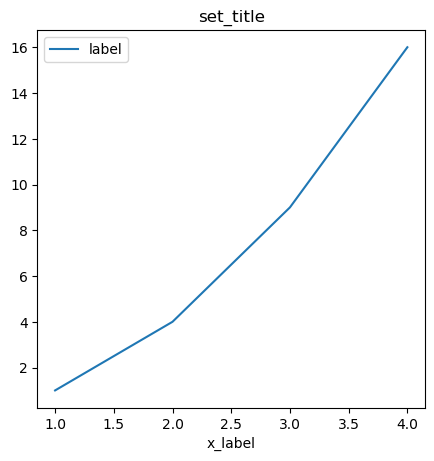

In [21]:
# you don't have to initialize the subplots if you need one seaborn plot with default settings
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)

# dummy data for show
x = np.array([1,2,3,4])
y = np.array([1,4,9,16])
sns.lineplot(x=x, y=y, ax=axes,label='label')

# settings for the subplot
axes.legend() 
axes.set_xlabel('x_label')
axes.set_title('set_title')
plt.show()

In [8]:
np.arange(1, 15 + 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

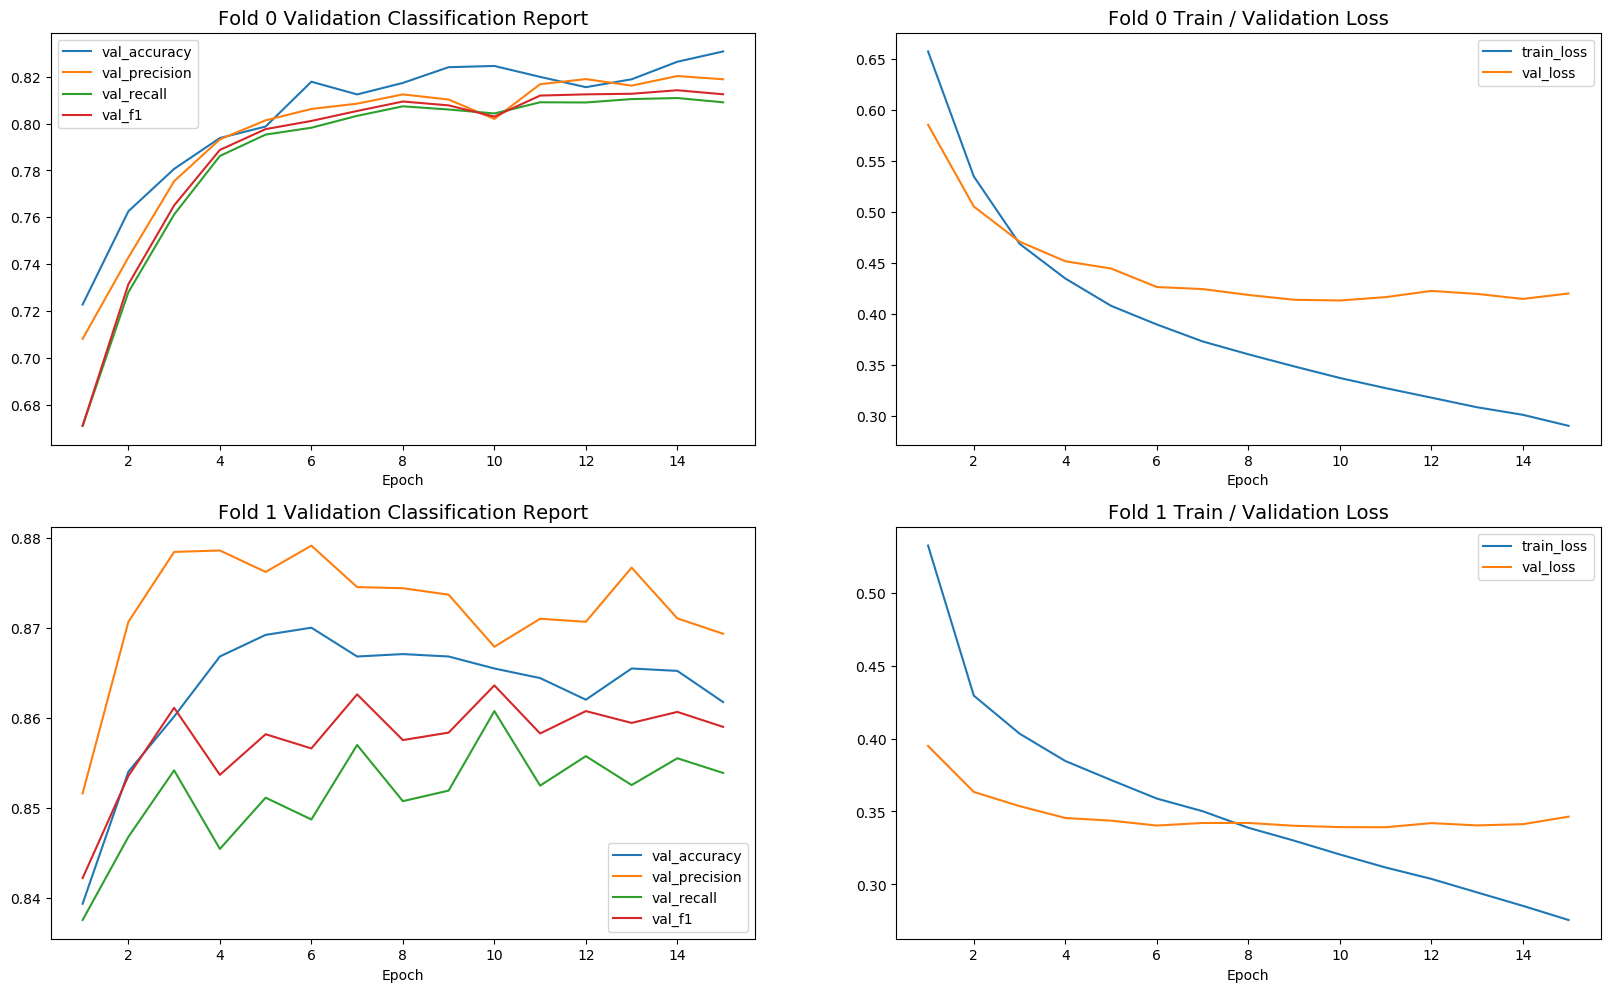

In [19]:
# create subgraphs in K rows and 2 columns. the height of each subfigure is 6, so- calculate 
# the size of the whole figure accordingly. The width of the whole figure is 20. set the dpi to be 100
fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
# loop for each fold
for i in range(K):
            
    # Classification Report curve
    # draw a curve of accuracy vs number of epochs on the first subplot
    sns.lineplot(x=np.arange(1, epochs + 1), y=history[i]['val_accuracy'], ax=axes[i][0], label='val_accuracy')
    
    # draw three curves of precision vs epochs, recall vs epochs and f1 vs epochs on the same 
    # first subplot of the fold
    sns.lineplot(x=np.arange(1, epochs + 1), y=scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
    sns.lineplot(x=np.arange(1, epochs + 1), y=scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
    sns.lineplot(x=np.arange(1, epochs + 1), y=scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

    # enable legends for the first subplot
    axes[i][0].legend() 
    
    # set the title for the first subplot
    axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

    # draw two plots of training loss vs epochs and validation loss vs epochs
    sns.lineplot(x=np.arange(1, epochs + 1), y=history[i]['loss'], ax=axes[i][1], label='train_loss')
    sns.lineplot(x=np.arange(1, epochs + 1), y=history[i]['val_loss'], ax=axes[i][1], label='val_loss')

    # enable legends for the second subplot
    axes[i][1].legend() 
    axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

    # set the label of x axis of both subplots
    for j in range(2):
        axes[i][j].set_xlabel('Epoch')
#         axes[i][j].tick_params(axis='x', labelsize=12)
#         axes[i][j].tick_params(axis='y', labelsize=12)

plt.show()

This is the cell which generates the submission file

In [ ]:
X=df_test
X_test_encoded = encode(X['text_cleaned'].str.lower())
y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

for model in models:
    y_pred += model.predict(X_test_encoded) / len(models)

model_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission.csv', index=False)

model_submission.describe()

### **8 Production**
This is the code to be used in production

In [1]:
print("Model initializing...")
max_seq_length=128
K=2

models=[0]*K
for fold in range(K):
    models[fold] = tf.keras.models.load_model('saved_model/my_model'+str(fold)+'/')

with open('saved_model/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

def encode(texts):                
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_seq_length - 2]
        input_sequence = ['[CLS]'] + text + ['[SEP]']
        pad_len = max_seq_length - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_seq_length

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def calculate(text):
    print("Analysing text...")
    data = {'text_cleaned':  [text]}
    columns=['text_cleaned']
    X = pd.DataFrame (data, columns = columns)
    X_test_encoded = encode(X['text_cleaned'].str.lower())
    y_pred = np.zeros((X_test_encoded[0].shape[0], 1))
    for model in models:
        y_pred += model.predict(X_test_encoded) / len(models)
    print("Analysis complete.")
    return np.round(y_pred).astype('int')[0,0]

# sample data
print('Model initialized')


Model initializing...
Model initialized


Now, use the calculate method to get the disaster prediction

In [ ]:
print(calculate("I love postcards"))